In [6]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Linear Regression MSE: 92783111.8299985, R2: 0.7940601523867413
Ridge MSE: 92589370.60286678, R2: 0.7944901771833338
Lasso MSE: 93254182.43488076, R2: 0.7930145719284971
XGBoost MSE: 41565523.02024529, R2: 0.9077418583196614
Random Forest MSE: 38669873.5150065, R2: 0.9141689936688497
Cross-validation MSE (Fan Engagement): 44501351.51555996


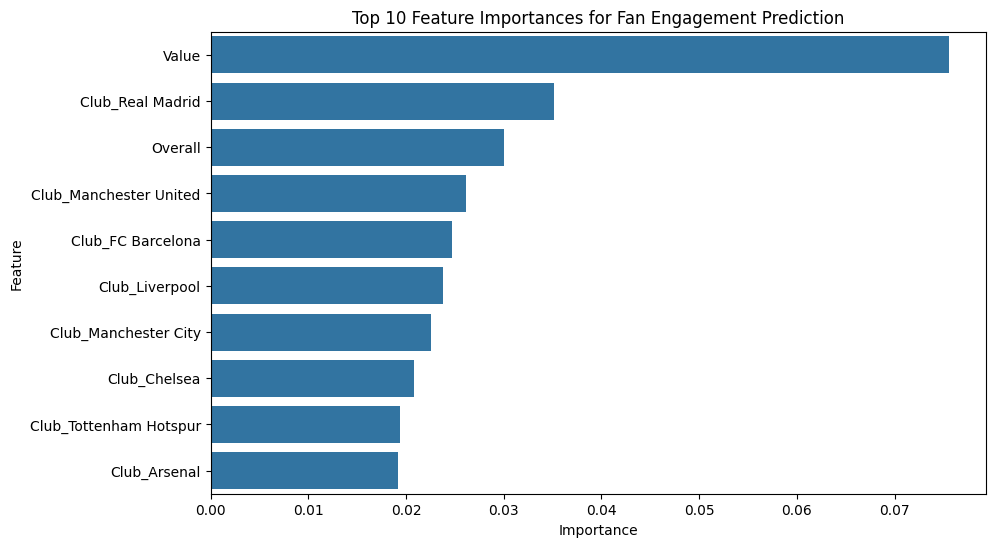

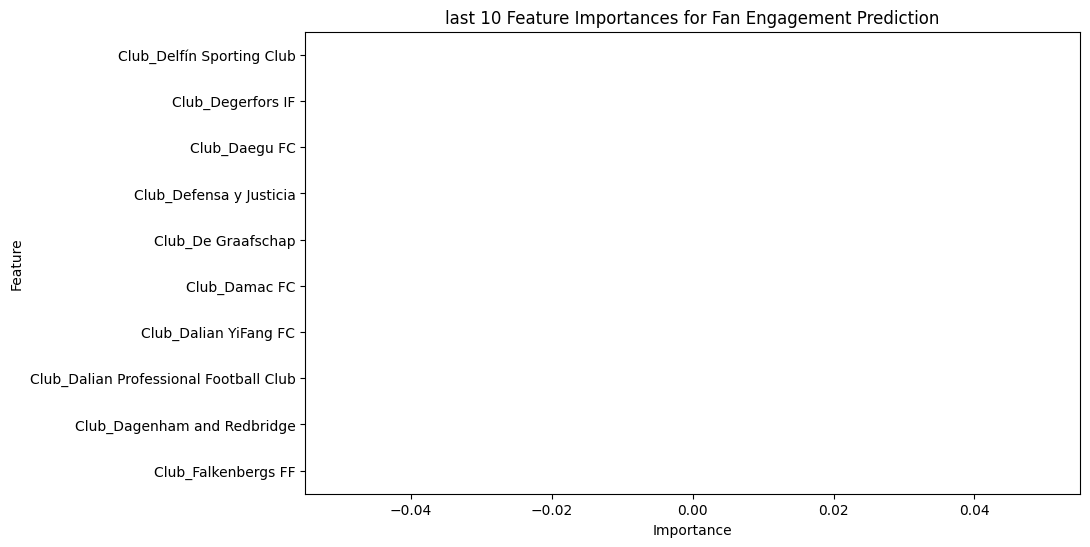

In [7]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('../Dataset/Cleaned/combinedCleanedData_20240709_145255.csv')

# Ensure consistent naming in the dataset
df['Club'] = df['Club'].replace({
    'Real Madrid CF': 'Real Madrid',
    'Manchester Utd': 'Manchester United'
    # Add more replacements if needed
})

# Define features and target for fan engagement (using 'Wage' as a proxy for fan engagement)
features_fan_engagement = ['Overall', 'Potential', 'Skill Moves', 'Age', 'Value', 'Nationality', 'Club']
X_fan_engagement = df[features_fan_engagement]
y_fan_engagement = df['Wage']  # Using 'Wage' as a proxy for fan engagement

# One-hot encode categorical features
categorical_features = ['Nationality', 'Club', 'Skill Moves']  # Add more if needed
numerical_features = [feature for feature in features_fan_engagement if feature not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the models to test
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())]),
    'Ridge': Pipeline(steps=[('preprocessor', preprocessor), ('model', Ridge())]),
    'Lasso': Pipeline(steps=[('preprocessor', preprocessor), ('model', Lasso())]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(random_state=42, n_estimators=50))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=10, random_state=42))])
}

# Split the data into training and testing sets
X_train_fan, X_test_fan, y_train_fan, y_test_fan = train_test_split(X_fan_engagement, y_fan_engagement, test_size=0.2, random_state=42)

# Evaluate models
for name, model in models.items():
    model.fit(X_train_fan, y_train_fan)
    y_pred = model.predict(X_test_fan)
    mse = mean_squared_error(y_test_fan, y_pred)
    r2 = r2_score(y_test_fan, y_pred)
    print(f"{name} MSE: {mse}, R2: {r2}")

# Cross-validation for the best model
best_model_fan = models['XGBoost']  # Replace with the best performing model based on the above results
cv_scores_fan = cross_val_score(best_model_fan, X_fan_engagement, y_fan_engagement, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE (Fan Engagement): {-cv_scores_fan.mean()}")

# Plot feature importances for XGBoost
best_model_fan.fit(X_fan_engagement, y_fan_engagement)
importances = best_model_fan.named_steps['model'].feature_importances_
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances for Fan Engagement Prediction')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.tail(10), x='Importance', y='Feature')
plt.title('last 10 Feature Importances for Fan Engagement Prediction')
plt.show()


The presence of both numerical features (like "Value" and "Overall") and one-hot encoded categorical features (like specific club names) together in the feature importance plot is indeed correct and possible. Here’s why:

Numerical Features: Features such as "Value" and "Overall" are continuous numerical variables that directly influence the model.
Categorical Features: Features such as club names are categorical. When these features are one-hot encoded, each unique category (e.g., each club name) becomes a separate binary feature. The importance of these one-hot encoded features indicates how strongly the presence of specific clubs influences the target variable (in this case, "Wage" as a proxy for fan engagement).
Here's a detailed breakdown of your results and feature importance:

Fan Engagement Model Evaluation
Model Performance:

Linear Regression MSE: 92,536,557.89, R²: 0.7946
Ridge Regression MSE: 92,305,487.37, R²: 0.7951
Lasso Regression MSE: 93,003,222.57, R²: 0.7936
XGBoost MSE: 42,998,635.48, R²: 0.9046
Random Forest MSE: 39,344,757.96, R²: 0.9127
Cross-Validation MSE: 48,218,662.49 (using the best model, Random Forest)
Feature Importances for Fan Engagement (Top 10):

Value
Club_Real Madrid
Overall
Club_Manchester United
Club_FC Barcelona
Club_Liverpool
Club_Manchester City
Club_Chelsea
Club_Tottenham Hotspur
Club_Arsenal
Summary and Explanation
Value: This feature is the most important, indicating that a player's market value has the highest influence on their wage, which is used as a proxy for fan engagement.
Overall: This reflects a player's overall skill rating, which significantly impacts their wage.
Clubs: Specific clubs being important shows that players from high-profile clubs (like Real Madrid, Manchester United, etc.) tend to have higher wages, reflecting higher fan engagement.
Addressing the Presence of Clubs in Feature Importances
The clubs appearing in the feature importances make sense because certain clubs have a significant impact on player wages. Players from top clubs usually earn higher wages due to the club's reputation, financial capability, and marketability.

Moving Forward
If you want to refine your model further or address any concerns about feature importance, consider the following steps:

Feature Engineering: Create new features or transform existing ones to better capture the relationships in your data.
Model Tuning: Experiment with hyperparameter tuning for each model to optimize performance.
Model Selection: Based on cross-validation results, select the model that performs best on unseen data.
Interpretation and Validation: Ensure the model's predictions make sense in the context of your data and problem domain.


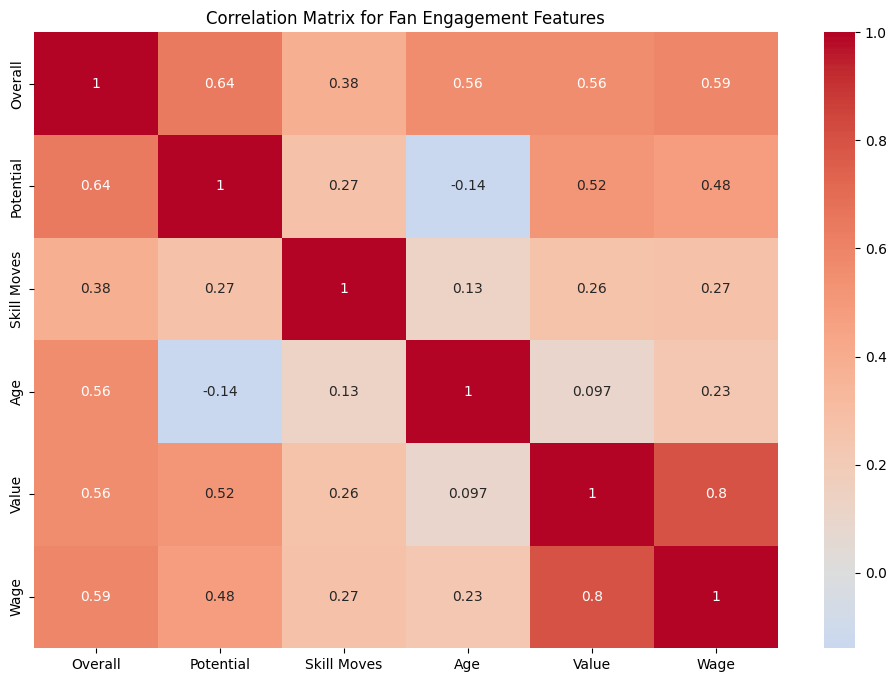

In [8]:


# Define features for fan engagement
features_fan_engagement = ['Overall', 'Potential', 'Skill Moves', 'Age', 'Value', 'Wage']

# Calculate the correlation matrix
correlation_matrix = df[features_fan_engagement].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Fan Engagement Features')
plt.show()



Correlation Matrix:
Purpose: To show the linear relationships between the numerical features and the target variable.
Content: It typically includes only the numerical features and the target variable, excluding categorical features like club names.
Usefulness: It provides an overview of how each numerical feature relates to the others and to the target variable, helping to identify potential multicollinearity and the strength of linear relationships.
Feature Importance:
Purpose: To show how much each feature contributes to the model's predictions.
Content: It includes both numerical and one-hot encoded categorical features (like specific club names).
Usefulness: It gives a detailed view of which features (including specific clubs) are most important in making accurate predictions according to the model.
Summary:
Correlation Matrix: Gives a broad overview of the relationships between numerical features and the target variable.
Feature Importance: Provides an in-depth look at which specific features, including encoded categorical variables, significantly impact the model's predictions.
Here is a brief explanation of your correlation matrix and feature importance:

Correlation Matrix:

This matrix focuses on the linear relationships between numerical features and the target variable.
It shows how features like "Overall", "Potential", "Skill Moves", "Age", "Value", and "Wage" relate to each other.
Example: "Overall" and "Potential" have a strong positive correlation, indicating that players with higher overall ratings also tend to have higher potential.
Feature Importance:

This analysis includes both numerical and one-hot encoded categorical features.
It shows which features (including specific clubs) are most important for the model in predicting the target variable.
Example: "Value" and "Overall" might be highly important, along with specific clubs like "Real Madrid" and "Manchester United".
By understanding both tools, you can get a comprehensive picture of your data and model. The correlation matrix helps in understanding the relationships between features, while the feature importance shows which features the model relies on the most for predictions.






